# **Cotents**
**1.Data Preparation**

**2. Model Preparation**

**3. Initial Data Visualization**

**4. Model Training**

**5. Post Data Visualization**

In [19]:
import torch
from torch import nn
import matplotlib.pyplot as plt

##**1. Data Preparation**

###**1.1 Data Loading**

In [20]:
from sklearn import datasets

iris = datasets.load_iris()

In [21]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

###**1.2 Data Selection**

In [22]:
# X = iris.data
X = iris.data[:,[1,3]]
y = iris.target
X.shape, y.shape

((150, 2), (150,))

In [23]:
X[:2]

array([[3.5, 0.2],
       [3. , 0.2]])

###**1.3 Data Split**

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 2), (30, 2), (120,), (30,))

###**1.4 Converting to tensor**

In [25]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([120, 2]), torch.Size([120]))

##**2. Model Preparation**

###**2.1 Model Defination**

In [26]:
class LogisticRegresssion(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer = nn.Sequential(
        nn.Linear(in_features=2, out_features=3),
    )

  def forward(self, x):
    return self.layer(x)

###**2.2 Instance of model**

In [27]:
torch.manual_seed(100)
model = LogisticRegresssion()
model.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[-0.5492,  0.4467],
                      [-0.3358, -0.0228],
                      [ 0.2496,  0.3591]])),
             ('layer.0.bias', tensor([-0.3356, -0.6465, -0.4129]))])

In [28]:
input_tensor = torch.tensor([5.1,0.2])
input_tensor

tensor([5.1000, 0.2000])

In [29]:
import numpy as np
model.eval()
with torch.inference_mode():
  logits = model(input_tensor)
  print(logits)
  probs = torch.nn.functional.softmax(logits, dim=0).numpy()
  print(probs)
  print(f"predicted class is: {np.argmax(probs)}")

tensor([-3.0471, -2.3636,  0.9319])
[0.01771525 0.03509167 0.9471931 ]
predicted class is: 2


##**3. Initial Data Visualizaiton**

###**3.1 Visualizer Function**

In [30]:
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    with torch.no_grad():
        logits = model(grid_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1).numpy()
    z = np.argmax(probs, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()


### **3.2 Plotting the Data**

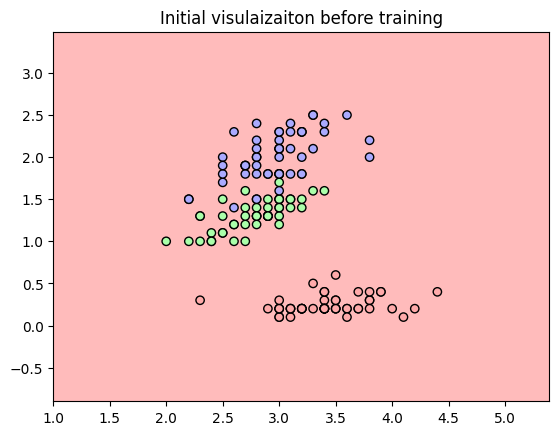

In [31]:
plot_decision_boundary(model, X, y, 'Initial visulaizaiton before training')

##**4. Model Training**

###**4.1 Loss and Optimizer**

In [32]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.1)

###**4.2 Training Loop**

In [33]:
def train_loop(model:nn.Module,
               X:torch.tensor,
               y:torch.tensor,
               loss_fn:nn.Module,
               optimizer:torch.optim,
               device:torch.device):

  X = X.to(device)
  y = y.to(device)
  model = model.to(device)

  #1.forward pass
  model.train()
  y_hat = model(X)
  # print(y)

  #2.loss calculation
  loss = loss_fn(y_hat,y)

  #3.optimizer zero_grad()
  optimizer.zero_grad()

  #4.loss.backward()
  loss.backward()

  #5.optimizer step
  optimizer.step()

  return loss


### **4.3 Test loop**

In [34]:
def test_loop(model:nn.Module,
               X:torch.tensor,
               y:torch.tensor,
               loss_fn:nn.Module,
               device:torch.device):

  X = X.to(device)
  y = y.to(device)
  model = model.to(device)

  model.eval()
  with torch.inference_mode():
    y_hat = model(X)

  loss = loss_fn(y_hat,y)
  return loss

###**4.4 Acutual Training**

**`Device configuaration`**

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [36]:
epochs = 1000
epoch_counter = []
train_loss_counter = []
test_loss_counter = []

for epoch in range(epochs):
  epoch_counter.append(epoch)
  train_loss = train_loop(model=model,
                          X=X_train_tensor,
                          y=y_train_tensor,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          device=device)
  train_loss_counter.append(train_loss)

  test_loss = test_loop(model=model,
                        X=X_test_tensor,
                        y=y_test_tensor,
                        loss_fn=loss_fn,
                        device=device)
  test_loss_counter.append(test_loss)

  if epoch % 100 == 0:
    print(f"Epoch:{epoch} | Train_loss: {train_loss} | Test_loss: {test_loss}")


Epoch:0 | Train_loss: 1.873462200164795 | Test_loss: 1.3640949726104736
Epoch:100 | Train_loss: 0.26757872104644775 | Test_loss: 0.229852095246315
Epoch:200 | Train_loss: 0.17849873006343842 | Test_loss: 0.1413556933403015
Epoch:300 | Train_loss: 0.14446239173412323 | Test_loss: 0.11062145978212357
Epoch:400 | Train_loss: 0.1276656836271286 | Test_loss: 0.09727341681718826
Epoch:500 | Train_loss: 0.11812523007392883 | Test_loss: 0.09090840071439743
Epoch:600 | Train_loss: 0.11222456395626068 | Test_loss: 0.08783140033483505
Epoch:700 | Train_loss: 0.10836268216371536 | Test_loss: 0.08644139021635056
Epoch:800 | Train_loss: 0.10573070496320724 | Test_loss: 0.0859539732336998
Epoch:900 | Train_loss: 0.10388093441724777 | Test_loss: 0.0859539806842804


In [37]:
model.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[  4.4807, -11.9576],
                      [  0.9151,  -2.0463],
                      [ -3.5741,  11.3253]])),
             ('layer.0.bias', tensor([ 1.4014,  4.4270, -4.3719]))])

###**4.5 Loss Curve**

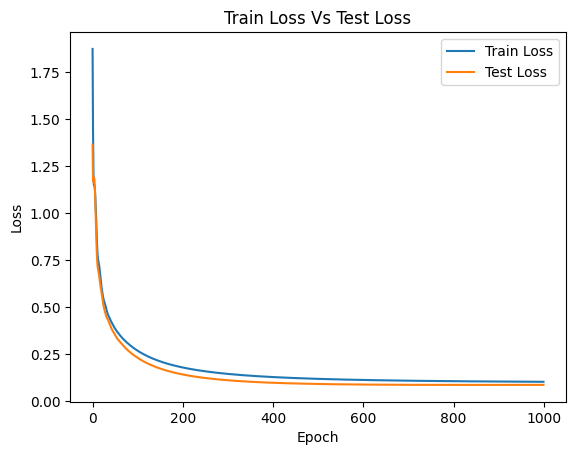

In [38]:
plt.plot(epoch_counter, torch.tensor(train_loss_counter).detach().cpu().numpy(), label="Train Loss")
plt.plot(epoch_counter, torch.tensor(test_loss_counter).detach().cpu().numpy(), label="Test Loss")
plt.title("Train Loss Vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## **5. Post Data Visualization**

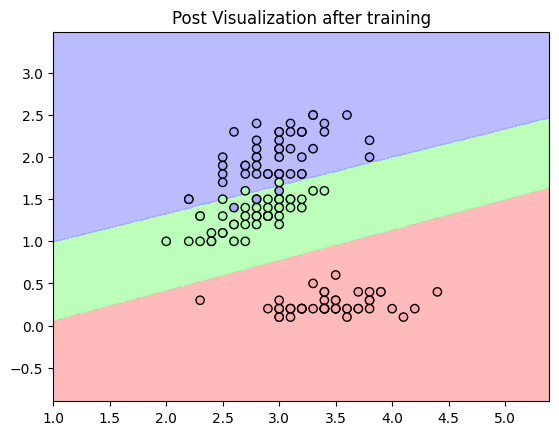

In [39]:
plot_decision_boundary(model.cpu(), X, y, 'Post Visualization after training')

###**Evaluating the Model**

In [40]:
input_tensor = torch.tensor([5.1,0.2])
input_tensor

tensor([5.1000, 0.2000])

In [41]:
model.eval()
with torch.inference_mode():
  logits = model(input_tensor)
  print(logits)
  probs = torch.nn.functional.softmax(logits, dim=0).numpy()
  print(probs)
  print(f"predicted class is: {np.argmax(probs)}")

tensor([ 21.8613,   8.6846, -20.3349])
[9.9999809e-01 1.8943409e-06 4.7251995e-19]
predicted class is: 0
